# SingleCell Data Analysis on the GPU
**Author:** [Severin Dicks](https://github.com/Intron7)

To run this notebook please make sure you have a working enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of 500000 brain cells from  [Nvidia](https://github.com/clara-parabricks/rapids-single-cell-examples/blob/master/notebooks/1M_brain_cpu_analysis.ipynb).

In [1]:
import scanpy as sc
import anndata
import cupy as cp

import time
import rapids_singlecell as rsc

import warnings
warnings.filterwarnings("ignore")

In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
rmm.reinitialize(
    managed_memory=False, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [3]:
data_load_start = time.time()

In [4]:
%%time
adata = sc.read("h5/500000.h5ad")
adata.var_names_make_unique()

CPU times: user 528 ms, sys: 2.59 s, total: 3.12 s
Wall time: 9.99 s


In [5]:
adata.shape

(500000, 27998)

In [6]:
%%time
rsc.utils.anndata_to_GPU(adata)

CPU times: user 412 ms, sys: 1.64 s, total: 2.05 s
Wall time: 2.05 s


Verify the shape of the resulting sparse matrix:

In [7]:
adata.shape

(500000, 27998)

In [8]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 12.102853775024414


## Preprocessing

In [9]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [10]:
%%time
rsc.pp.flag_gene_family(adata,gene_family_name="MT", gene_family_prefix="mt-")

CPU times: user 5.07 ms, sys: 288 µs, total: 5.35 ms
Wall time: 5.19 ms


In [11]:
%%time
rsc.pp.calculate_qc_metrics(adata,qc_vars=["MT"])

CPU times: user 146 ms, sys: 9.74 ms, total: 156 ms
Wall time: 235 ms


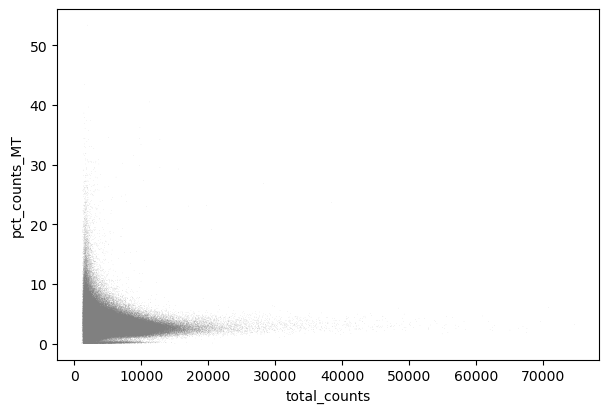

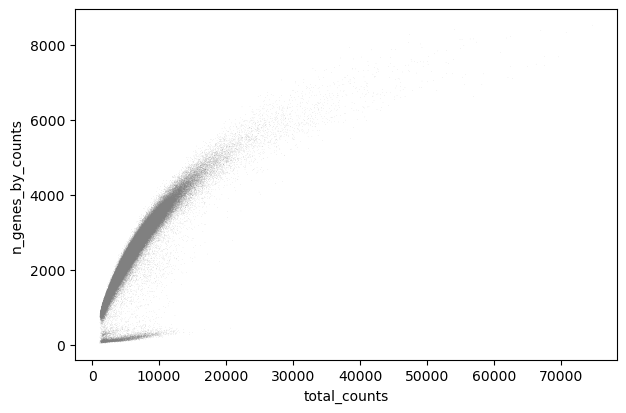

In [12]:
sc.pl.scatter(adata,"total_counts","pct_counts_MT")
sc.pl.scatter(adata,"total_counts","n_genes_by_counts")

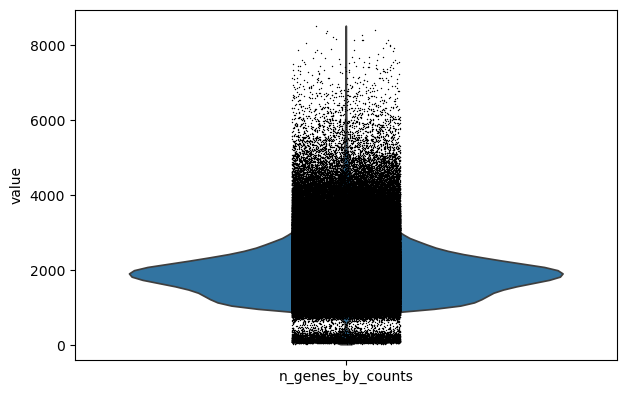

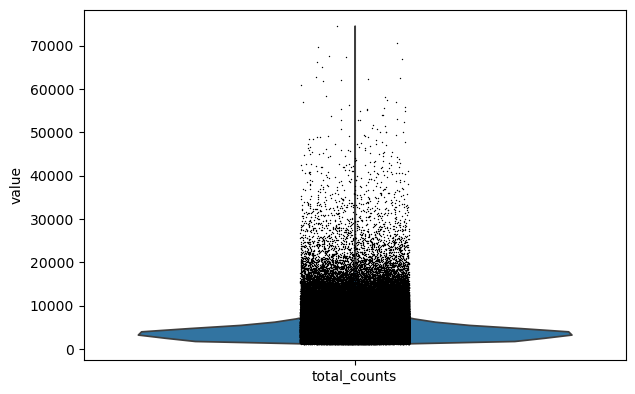

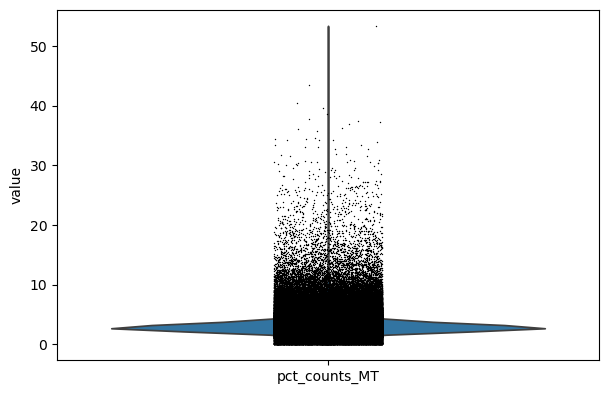

In [13]:
sc.pl.violin(adata,keys="n_genes_by_counts")
sc.pl.violin(adata,keys="total_counts")
sc.pl.violin(adata,keys="pct_counts_MT")

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

In [14]:
%%time
adata = adata[adata.obs["n_genes_by_counts"] < 5000]
adata = adata[adata.obs["n_genes_by_counts"] > 500]

adata.shape

CPU times: user 19.4 ms, sys: 4.49 ms, total: 23.9 ms
Wall time: 22.7 ms


(492660, 27998)

In [15]:
%%time
adata = adata[adata.obs["pct_counts_MT"] < 20]
adata.shape

CPU times: user 10 ms, sys: 1.26 ms, total: 11.3 ms
Wall time: 11 ms


(492376, 27998)

We also filter out genes that are expressed in less than 3 cells.

In [16]:
%%time
rsc.pp.filter_genes(adata,min_count=3)

filtered out 6139 genes based on n_cells_by_counts
CPU times: user 441 ms, sys: 45.9 ms, total: 487 ms
Wall time: 502 ms


We store the raw expression counts in the `.layer["counts"]`

In [17]:
adata.layers["counts"] = adata.X.copy()

In [18]:
adata.shape

(492376, 21859)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [19]:
%%time
rsc.pp.normalize_total(adata,target_sum=1e4)

CPU times: user 0 ns, sys: 1.3 ms, total: 1.3 ms
Wall time: 7.38 ms


Next, we log transform the count matrix.

In [20]:
%%time
rsc.pp.log1p(adata)

CPU times: user 30.6 ms, sys: 3.8 ms, total: 34.4 ms
Wall time: 35.9 ms


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `seurat_v3` for selecting highly variable genes based on the raw counts in `.layer["counts"]`

In [21]:
%%time
rsc.pp.highly_variable_genes(adata,n_top_genes=5000,flavor="seurat_v3",layer = "counts")

CPU times: user 2.91 s, sys: 3.37 s, total: 6.28 s
Wall time: 2.45 s


Now we safe this verion of the AnnData as adata.raw.

In [22]:
%%time
adata.raw = adata

CPU times: user 662 ms, sys: 460 ms, total: 1.12 s
Wall time: 1.12 s


Now we restrict our AnnData object to the highly variable genes.

In [23]:
%%time
adata = adata[:,adata.var["highly_variable"]==True]

CPU times: user 432 ms, sys: 475 ms, total: 908 ms
Wall time: 909 ms


In [24]:
adata.shape

(492376, 5000)

Next we regess out effects of counts per cell and the mitochondrial content of the cells. As you can with scanpy you can use every numerical column in `.obs` for this.

In [25]:
%%time
rsc.pp.regress_out(adata,keys=["total_counts", "pct_counts_MT"])

CPU times: user 2.84 s, sys: 2.11 s, total: 4.95 s
Wall time: 5.18 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations.

In [26]:
%%time
rsc.pp.scale(adata,max_value=10)

CPU times: user 223 ms, sys: 18.2 ms, total: 241 ms
Wall time: 1.01 s


### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from `rapids-singlecell` that uses cuMLs PCA to run this.

In [27]:
%%time
rsc.pp.pca(adata, n_comps = 100)

CPU times: user 2.6 s, sys: 107 ms, total: 2.7 s
Wall time: 4.15 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

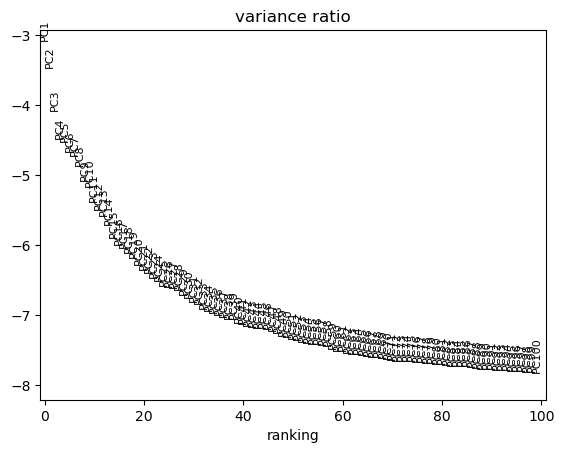

In [28]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=100)

Now we move `.X` and `.layers` out of the GPU.

In [29]:
%%time
rsc.utils.anndata_to_CPU(adata, convert_all=True)

CPU times: user 935 ms, sys: 687 ms, total: 1.62 s
Wall time: 1.62 s


In [30]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 26.064983367919922


We have now finished the preprocessing of the data.

## Clustering and Visulization

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using rsc.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the excat graph. Both methods are valid, but you might see differences.

In [31]:
%%time
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=60)

CPU times: user 5.04 s, sys: 74.7 ms, total: 5.11 s
Wall time: 5.12 s


Next we calculate the UMAP embedding using rapdis.

In [32]:
%%time
rsc.tl.umap(adata)

CPU times: user 1.21 s, sys: 57.4 ms, total: 1.27 s
Wall time: 1.26 s


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering.

In [33]:
%%time
rsc.tl.louvain(adata, resolution=0.6)

CPU times: user 4.66 s, sys: 4.35 s, total: 9 s
Wall time: 11.4 s


In [34]:
%%time
rsc.tl.leiden(adata,resolution=0.6)

CPU times: user 1.14 s, sys: 2.88 s, total: 4.03 s
Wall time: 4.03 s


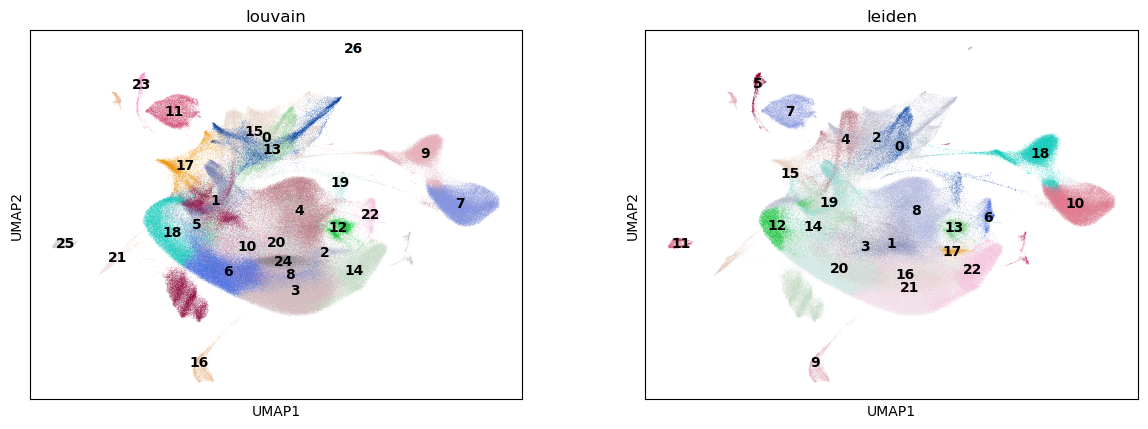

CPU times: user 2.45 s, sys: 177 ms, total: 2.62 s
Wall time: 2.45 s


In [35]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

## TSNE

In [36]:
%%time
rsc.tl.tsne(adata, n_pcs = 40)

[W] [16:41:45.226021] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 7.93 s, sys: 4.88 s, total: 12.8 s
Wall time: 12.8 s


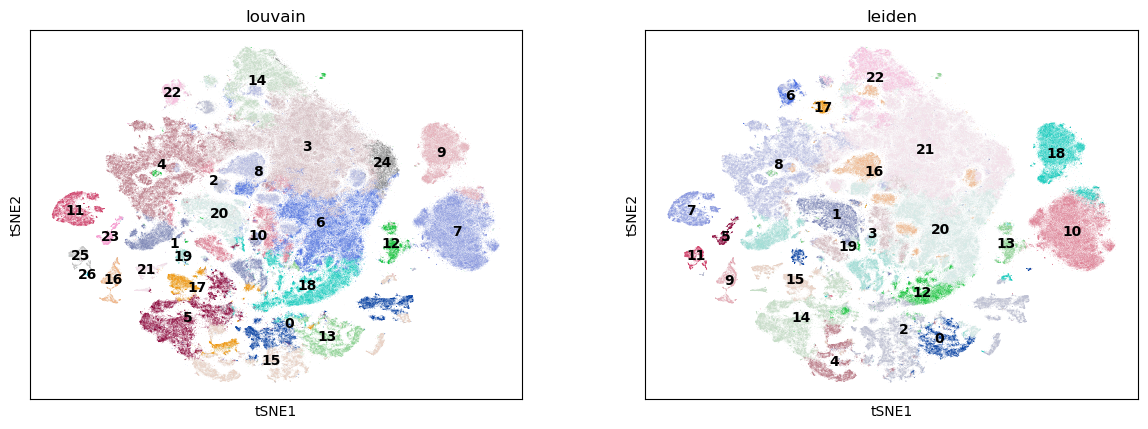

In [37]:
sc.pl.tsne(adata,color=["louvain","leiden"], legend_loc='on data')

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvaincluster.

In [38]:
%%time
rsc.tl.rank_genes_groups_logreg(adata, groupby="louvain", use_raw=False)

[W] [16:42:28.252660] L-BFGS: max iterations reached
[W] [16:42:28.253231] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
CPU times: user 19.2 s, sys: 8.64 s, total: 27.8 s
Wall time: 27.9 s


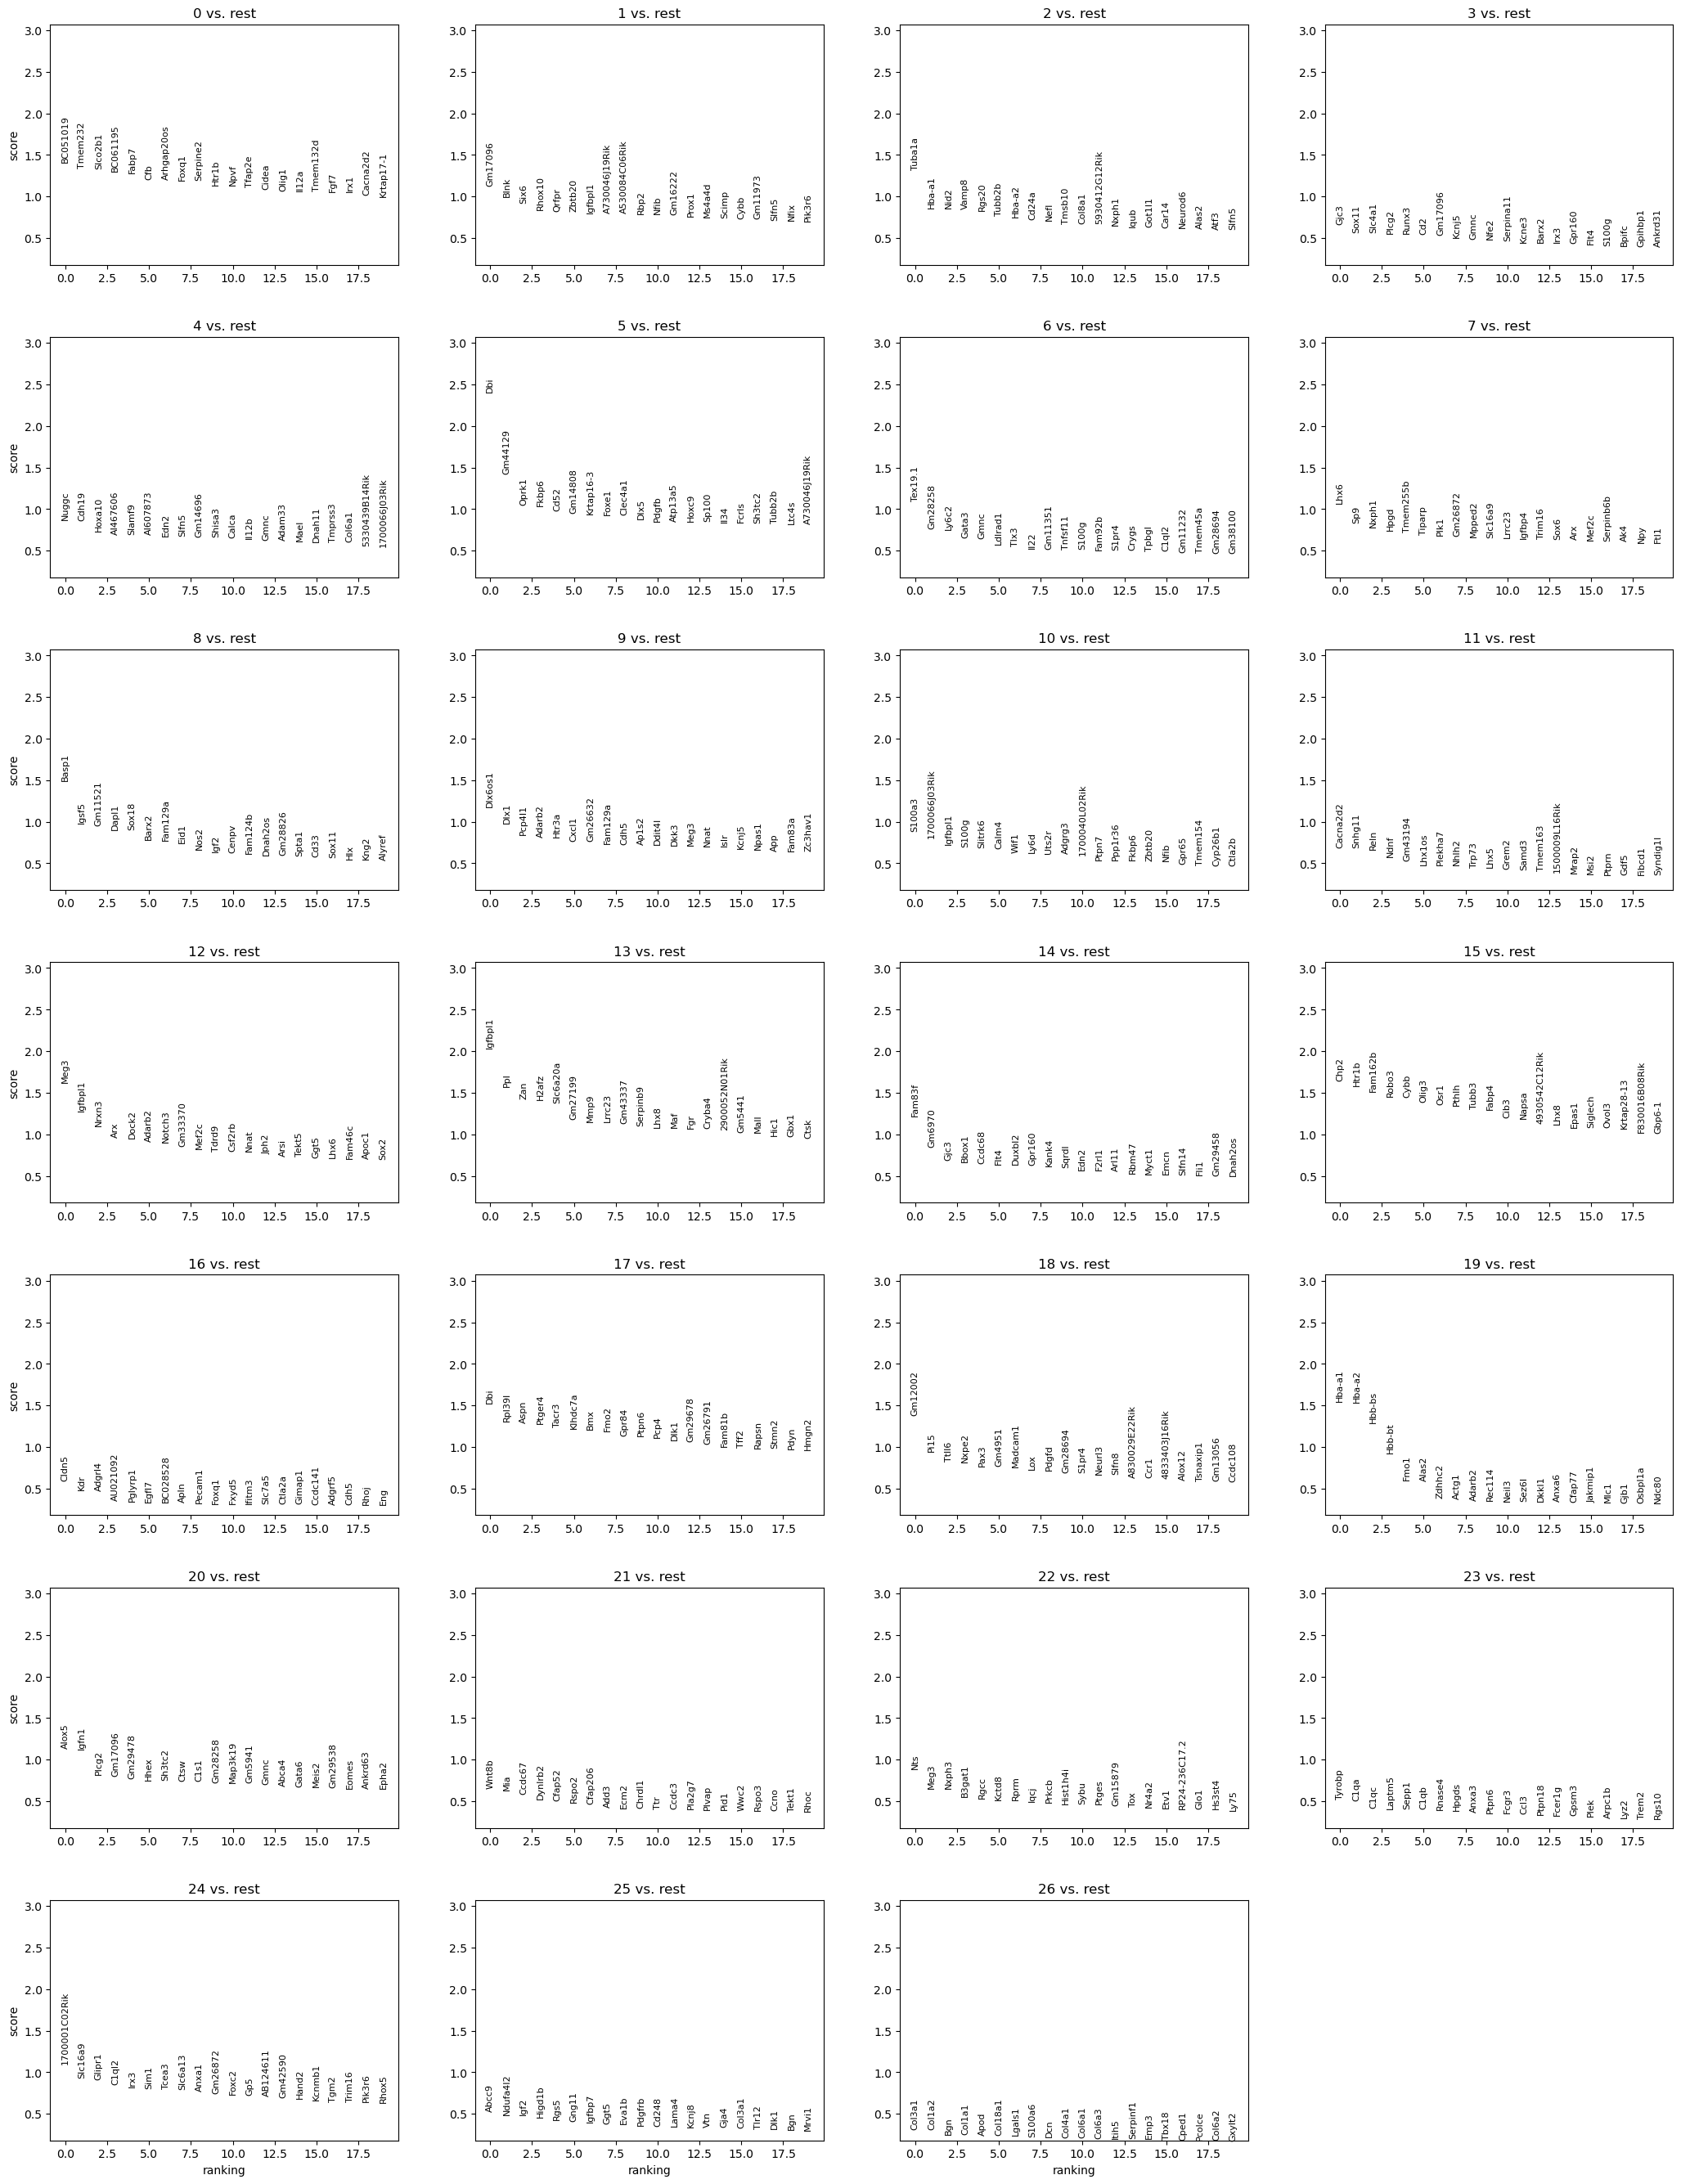

CPU times: user 2.74 s, sys: 195 ms, total: 2.93 s
Wall time: 2.75 s


In [39]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

## Diffusion Maps

In [40]:
%%time
rsc.tl.diffmap(adata)
adata.obsm["X_diffmap"] = adata.obsm["X_diffmap"][:, 1:] 

CPU times: user 1.56 s, sys: 5.77 s, total: 7.33 s
Wall time: 724 ms


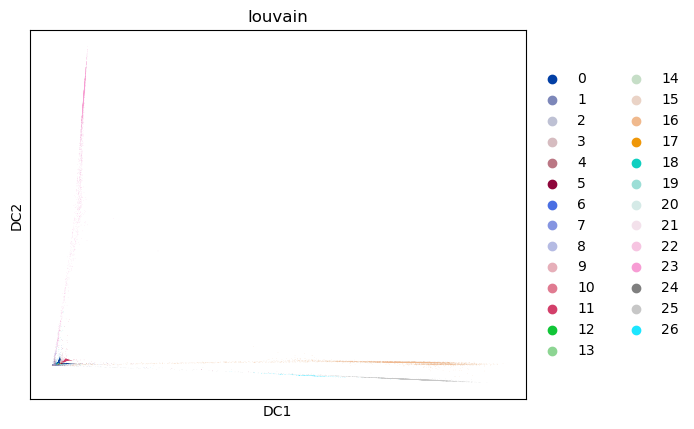

In [41]:
sc.pl.diffmap(adata, color='louvain')

After this you can use `X_diffmap` for `sc.pp.neighbors` and other fuctions. 

In [42]:
print("Total Processing time: %s" % (time.time()-preprocess_start))

Total Processing time: 98.41323256492615
